# **USE CASE 3.** VFL using Decision Trees with FATE

## Initialize FATE

Prior to the execution of the FATE code, the user may initialize FATE as seen in their [webpage](https://fate.readthedocs.io/en/latest/deploy/standalone-deploy/#3-install-fate-in-the-host-using-the-compiled-installer). The following commands are commented, so the user may uncomment them if needed; i.e., if FATE has not been initialized so far in this session. We assume that FATE has been already installed as indicated in their [webpage](https://fate.readthedocs.io/en/latest/deploy/standalone-deploy/#3-install-fate-in-the-host-using-the-compiled-installer).

In [1]:
# Move to the folder where FATE standalone has been downloaded. Modify the path as required.
#!cd /path/to/standalone_fate_install_1.10.0_release

# Start FATE service
#!bash bin/init.sh start

# Load environment variables
#!source bin/init_env.sh

# Initialize FATE's pipeline
#!pipeline init --ip 127.0.0.1 --port 9380

## Required libraries and configuration

Import required libraries

In [2]:
import os
import argparse

from pipeline.backend.pipeline import PipeLine
from pipeline.component import Reader, DataTransform, Intersection, HeteroSecureBoost, Evaluation
from pipeline.interface import Data

from pipeline.utils.tools import load_job_config

Define some parameters for the simulation, such as the host and guest ports in the federated scenario using the FATE framework.

Besides, FATE provides some datasets ready to use with their framework. To use them, we just cloned their whole [GitHub repository](https://github.com/FederatedAI/FATE) in our local machine, in the ``data_base`` path.

In [3]:
guest = 10000
host = 10001

# Path to the FATE repositoty in the local machine.
data_base = "/workspace/FATE/"

namespace = "CU_2_FATE"

FATE uses a pipeline with components that are connected between them once added.
First of all, we initialize the pipeline and set the roles of each client.

In [4]:
# Initialize the pipeline
pipeline = PipeLine()

# Set job initiator; the guest (client with label data) initiates the process
pipeline.set_initiator(role='guest', party_id=guest)

# Set participants information
pipeline.set_roles(guest=guest, host=host)

## Loading and preparing the input data

First, we have to define the data tables and namespace, which will be used later in the FATE job configuration.

In [5]:
guest_train_data = {"name": "default_credit_hetero_guest", "namespace": f"experiment{namespace}"}
host_train_data = {"name": "default_credit_hetero_host", "namespace": f"experiment{namespace}"}

Upload the data to the pipeline. For each of them, indicate the csv file with the corresponding client data, the table name and namespace (previously defined). Besides, the ``extend_sid`` parameter allows to keep the id of each instance in the data, so they can be later identified and matched.

In [6]:
# Upload the data to the FATE framework before reading it.
pipeline.add_upload_data(
    file=os.path.join(data_base, "examples/data/default_credit_hetero_guest.csv"),
    table_name=guest_train_data["name"],
    namespace=guest_train_data["namespace"],
    extend_sid=True
)

pipeline.add_upload_data(
    file=os.path.join(data_base, "examples/data/default_credit_hetero_host.csv"),
    table_name=host_train_data["name"],
    namespace=host_train_data["namespace"],
    extend_sid=True
)

# Upload the data that we have previously added.
# The drop=1 forces to upload the data although a previous version was already uploaded
pipeline.upload(drop=1)

 UPLOADING:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||100.00%


2023-02-22 08:39:20.880 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:83 - Job id is 202302220839203913730

2023-02-22 08:39:20.891 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:00
m2023-02-22 08:39:21.943 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:125 - 
2023-02-22 08:39:21.947 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:01
2023-02-22 08:39:22.965 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:02
2023-02-22 08:39:23.978 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:03
2023-02-22 08:39:25.001 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:04
2023-02-22 08:39:26.011 | INFO     

 UPLOADING:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||100.00%


2023-02-22 08:39:26.485 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:83 - Job id is 202302220839260204460

2023-02-22 08:39:26.493 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:00
2023-02-22 08:39:27.502 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:01
m2023-02-22 08:39:28.524 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:125 - 
2023-02-22 08:39:28.525 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:02
2023-02-22 08:39:29.542 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:03
2023-02-22 08:39:30.558 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:04
2023-02-22 08:39:31.574 | INFO     | pipel

Then, we define the ``Reader`` component that will later be included to in the pipeline. This component is in charge of reading the data from the guest and host parties.

In [7]:
# Define Reader components to read in data
reader_0 = Reader(name="reader_0")

# Configure Reader for guest
reader_0.get_party_instance(role='guest', party_id=guest).component_param(table=guest_train_data)
# Configure Reader for host
reader_0.get_party_instance(role='host', party_id=host).component_param(table=host_train_data)

Due to the characteristics of the vertically partitioned federated scenario, the data between the different clients must be alligned by id (i.e., only the data that share ID in all clients is used). 
For that purpose, we first create a ``DataTransform`` component indicating that the data will be matched by id.

Finally, the ``Intersection`` component finalizes with the data alignment.

In [8]:
data_transform_0 = DataTransform(name="data_transform_0", with_match_id=True)

# data_transform_0_guest_party_instance = data_transform_0.get_party_instance(role='guest', party_id=guest)
data_transform_0.get_party_instance(role='guest', party_id=guest).\
    component_param(with_label=True, output_format="dense")

data_transform_0.get_party_instance(role='host', party_id=host).\
    component_param(with_label=False)

intersection_0 = Intersection(name="intersection_0")

## Create the SecureBoost model

SecureBoost is a VFL model based on decision trees proposed in 2019 by [Cheng *et al.*](https://arxiv.org/abs/1901.08755).
In the next cell, we create an object of the ``HeteroSecureBoost`` FATE class to use such model later in the federated training process. 
Here, we may indicate some parameters such as the task type and objective for the boosting process, the encrypt method, the number of trees or boosting iterations, and other tree parameters such as the maximum depth.

In [9]:
# Define the model
hetero_secureboost_0 = HeteroSecureBoost(name="hetero_secureboost_0",
                                         task_type="classification", # by default
                                         objective_param={"objective": "cross_entropy"},
                                         encrypt_param={"method": "paillier"},
                                         num_trees=10,
                                         tree_param={"max_depth": 3}
                                        )

## Configure the Pipeline and its components

As previously stated, in FATE we have to create a Pipeline and then add the components that we want to use to train/predict in the federated scenario. They are added in the given order of task execution.

We have previously declared most of the components, such as the ``Reader``, ``DataTransform``, ``Intersection`` and ``HeteroSecureBoost``, so we add them to the pipeline. Note that the input data to each component is the output data from the previous one.

In [10]:
pipeline.add_component(reader_0)
pipeline.add_component(data_transform_0, data=Data(data=reader_0.output.data))
pipeline.add_component(intersection_0, data=Data(data=data_transform_0.output.data))
pipeline.add_component(hetero_secureboost_0, data=Data(train_data=intersection_0.output.data))

Besides, we also create and add to the pipeline an ``Evaluation`` component, that configures the evaluation strategy; in this case, binary since the dataset has two classes.

In [11]:
# Define the evaluation strategy
evaluation_0 = Evaluation(name='evaluation_0', eval_type='binary')

# Add to the pipeline
pipeline.add_component(evaluation_0, data=Data(data=hetero_secureboost_0.output.data))

## Training in the federated scenario

Once we have the pipeline with all the components ready, we just compile the pipeline and use the fit method.

In [12]:
# Compile pipeline once finished adding modules, this step will form conf and dsl files for running job
pipeline.compile()

In [13]:
# Fit model
pipeline.fit()

2023-02-22 08:39:32.922 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:83 - Job id is 202302220839326582720

2023-02-22 08:39:32.927 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:00
2023-02-22 08:39:33.937 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:01
m2023-02-22 08:39:34.960 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:125 - 
2023-02-22 08:39:34.961 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader_0, time elapse: 0:00:02
2023-02-22 08:39:35.976 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader_0, time elapse: 0:00:03
2023-02-22 08:39:36.990 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader_0, time elapse: 0:00:04
2023-02-22 08:39:38.014 | INFO     | pipel

We can check the results of the model in different ways. The first one is using the component with the evaluation strategy defined in the pipeline

In [14]:
# Query component summary
print(f"Evaluation summary: {pipeline.get_component('evaluation_0').get_summary()}")

Evaluation summary: {'hetero_secureboost_0': {'train': {'auc': 0.7786938013217246, 'ks': 0.42709088927711536}}}


The other method to check the results obtained by the model, is to log into the FATE interface and check the evaluation component. Using the interface, we can also check the tree structure at the gust and at the host.

By default, the FATE board is available at: [127.0.0.1:8080](http://127.0.0.1:8080)

## Evaluation with test data

In order to evaluate the model with new data, we have to create a new pipeline. In this example we will use the training data as test data, just to show how to define a pipeline for testing the model.

We have to upload the test data to the platform, but as we are using the training data, we just select it.

In [15]:
guest_eval_data = {"name": "default_credit_hetero_guest", "namespace": f"experiment"}
host_eval_data = {"name": "default_credit_hetero_host", "namespace": f"experiment"}

We need to deploy the main components from our main pipeline, those are:
- DataTransform: Apply the same preprocessing to the incoming data
- Intersection: Apply the intersection by ID to the data.
- HeteroSecureBoost: The model to use.

In [16]:
# Deploy required components
pipeline.deploy_component([data_transform_0, intersection_0, hetero_secureboost_0])

In [17]:
#Initiate predict pipeline
predict_pipeline = PipeLine()

# Create the reader component
reader_1 = Reader(name='reader1')
reader_1.get_party_instance(role='guest', party_id=guest).component_param(table=guest_eval_data)
reader_1.get_party_instance(role='host', party_id=host).component_param(table=host_eval_data)

# Add data reader onto predict pipeline
predict_pipeline.add_component(reader_1)

predict_pipeline.add_component(pipeline,
                              data=Data(predict_input={pipeline.data_transform_0.input.data: reader_1.output.data}))

Now we can use the pipeline to predict

In [18]:
# Run predict model
predict_pipeline.predict()

2023-02-22 08:44:41.049 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:83 - Job id is 202302220844408387870

2023-02-22 08:44:41.057 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:00
m2023-02-22 08:44:42.070 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:125 - 
2023-02-22 08:44:42.071 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader1, time elapse: 0:00:01
2023-02-22 08:44:43.137 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader1, time elapse: 0:00:02
2023-02-22 08:44:44.160 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader1, time elapse: 0:00:03
2023-02-22 08:44:45.173 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader1, time elapse: 0:00:04
m2023-02-22 08:44:47.264 | INFO     | p

In order to check the results, we should log into the FATE board.

## FATE Board

Using the board provided by the FATE framework (By default, available at: [127.0.0.1:8080](http://127.0.0.1:8080)), we can check the some extra details. For example, the image below shows the tree at the host, where the host can view only those nodes generated by him.

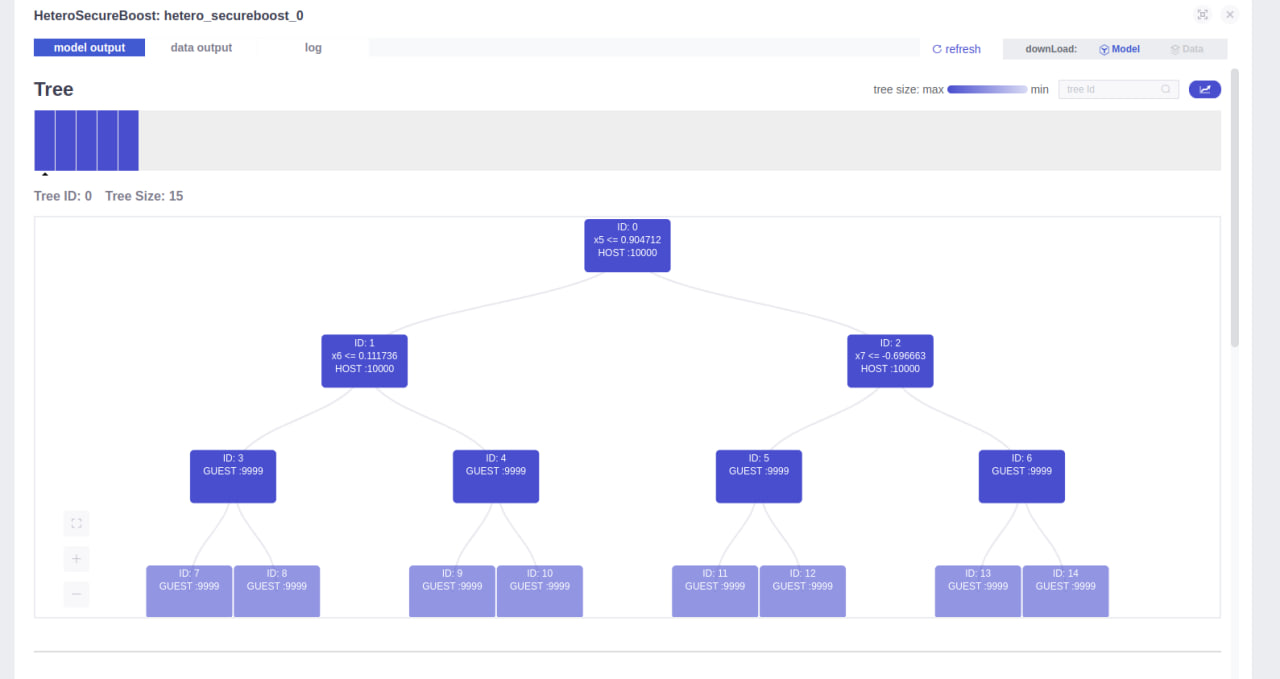

We can also check the evaluation component.

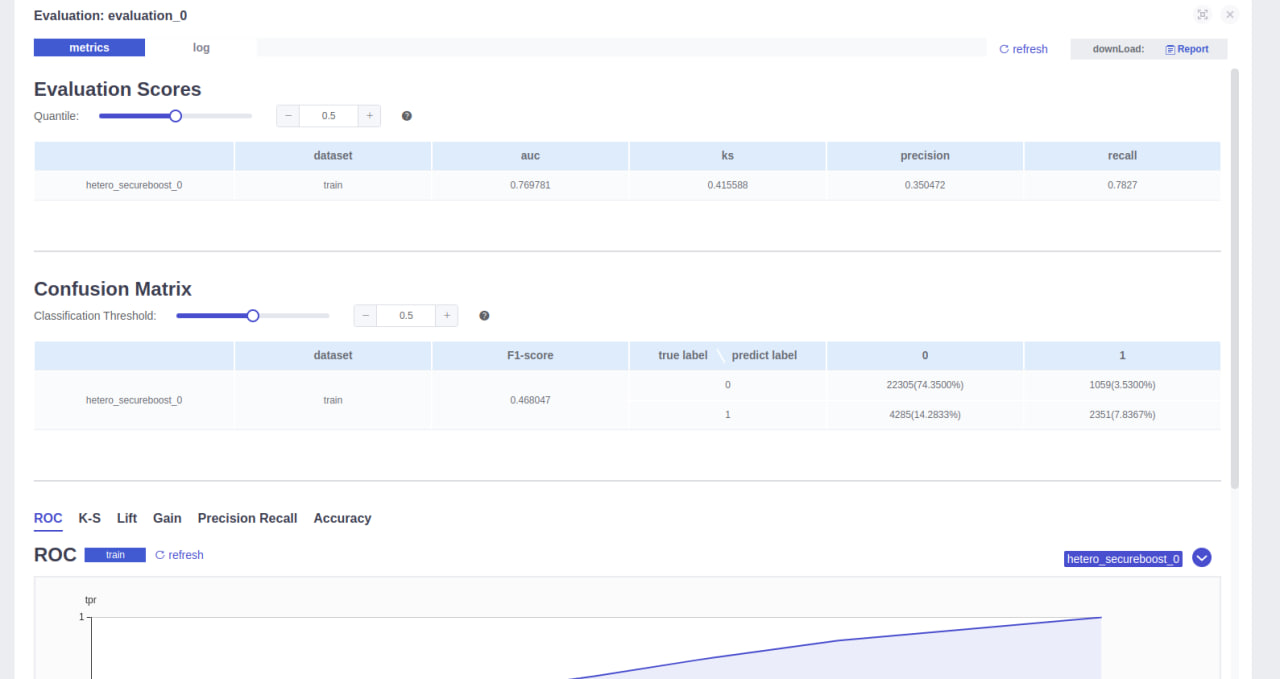